In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [02:09<00:00, 42.2MB/s]
100% 5.11G/5.11G [02:09<00:00, 42.2MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lyft-udacity-challenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import imageio.v3 as iio

In [34]:
from glob import glob
from scipy.io import loadmat

Text(0.5, 1.0, 'Segmentation')

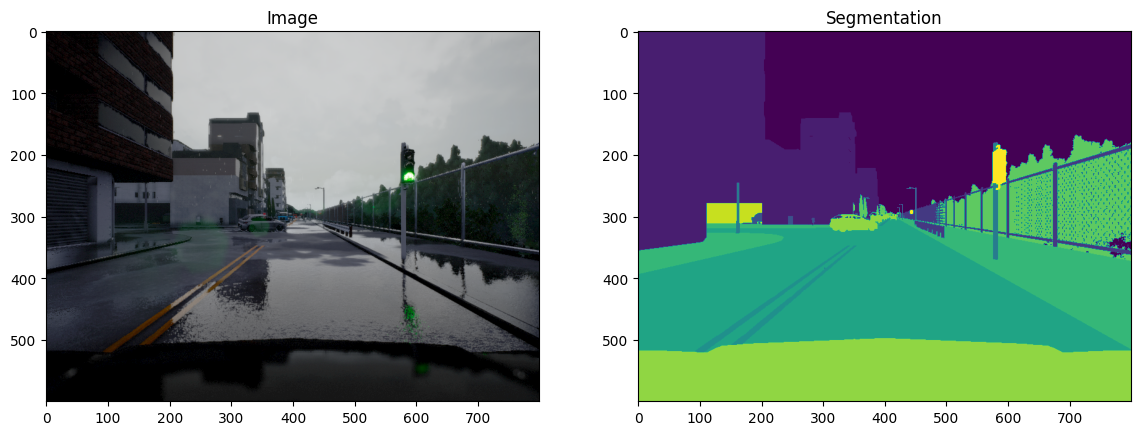

In [62]:
image_path = ('/content/dataA/dataA/CameraRGB/')
mask_path = ('/content/dataA/dataA/CameraSeg/')
test_path = ('/content/dataB/dataB/CameraRGB/')
test_mask = ('/content/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img =  iio.imread(image_list[12])
mask = iio.imread(mask_list[12])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [63]:
len(image_list)

1000

In [64]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [65]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

**No skip connections**

In [66]:
IMAGE_SIZE = 256
NUM_CLASSES = 23

In [67]:
def AtrousSpatialPyramidPooling(model_input):
  dims = tf.keras.backend.int_shape(model_input)

  layer = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],
                                                      dims[-2]))(model_input)
  layer = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same',
                                 kernel_initializer = 'he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  out_pool = tf.keras.layers.UpSampling2D(size = (dims[-3] // layer.shape[1],
                                               dims[-2] // layer.shape[2]),
                                        interpolation = 'bilinear')(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_1 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 6, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_6 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 12, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_12 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 18, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_18 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])

  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  model_output = tf.keras.layers.ReLU()(layer)
  return model_output

In [68]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    layer = resnet50.get_layer('conv4_block6_2_relu').output
    layer = AtrousSpatialPyramidPooling(layer)

    input_a = tf.keras.layers.UpSampling2D( 
      size=(image_size // 4 // layer.shape[1], image_size // 4 // layer.shape[2]),
      interpolation="bilinear",
    )(layer)

    input_b = resnet50.get_layer("conv2_block3_2_relu").output

    input_b = tf.keras.layers.Conv2D(48, kernel_size = (1,1), padding = 'same',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(input_b)


    input_b = tf.keras.layers.BatchNormalization()(input_b)
    input_b = tf.keras.layers.ReLU()(input_b)

    layer = tf.keras.layers.Concatenate(axis = -1)([input_a, input_b])



    layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(256, kernel_size =3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)


    layer = tf.keras.layers.UpSampling2D(size = (image_size // layer.shape[1],
                                              image_size // layer.shape[2]),
                                              interpolation = 'bilinear')(layer)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(layer)

    return keras.Model(inputs=model_input, outputs=model_output)

In [69]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [70]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [72]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) 
        plt.axis('off')
    plt.show()

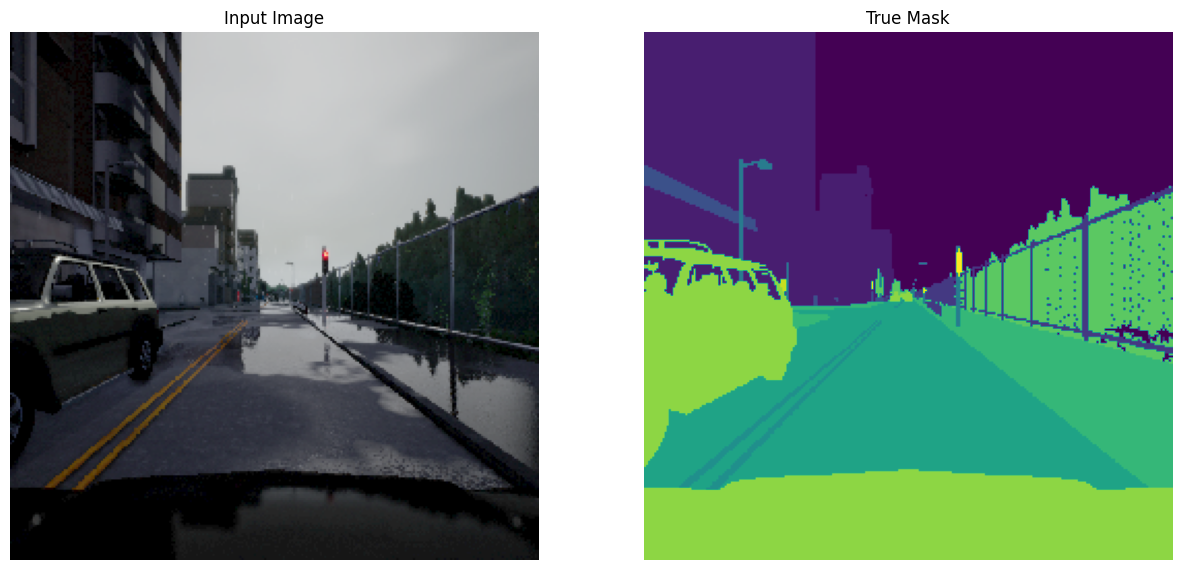

In [73]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [74]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model.fit(train_dataset,validation_data=tests_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/50
32/32 [==============================] - 94s 2s/step - loss: 0.5710 - updated_mean_io_u_5: 0.2070 - accuracy: 0.8451 - val_loss: 4.5599 - val_updated_mean_io_u_5: 0.0500 - val_accuracy: 0.2716
Epoch 2/50
32/32 [==============================] - 31s 975ms/step - loss: 0.2280 - updated_mean_io_u_5: 0.4798 - accuracy: 0.9215 - val_loss: 1.6837 - val_updated_mean_io_u_5: 0.1470 - val_accuracy: 0.5887
Epoch 3/50
32/32 [==============================] - 31s 982ms/step - loss: 0.1866 - updated_mean_io_u_5: 0.5438 - accuracy: 0.9336 - val_loss: 1.6786 - val_updated_mean_io_u_5: 0.1679 - val_accuracy: 0.6495
Epoch 4/50
32/32 [==============================] - 31s 985ms/step - loss: 0.1632 - updated_mean_io_u_5: 0.5929 - accuracy: 0.9404 - val_loss: 1.4748 - val_updated_mean_io_u_5: 0.2204 - val_accuracy: 0.6858
Epoch 5/50
32/32 [==============================] - 

In [75]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


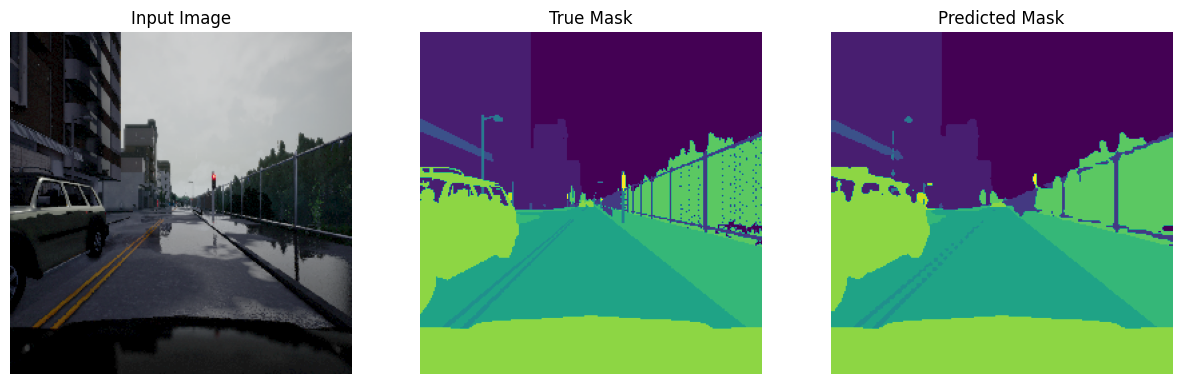

1/1 [==============================] - 0s 82ms/step


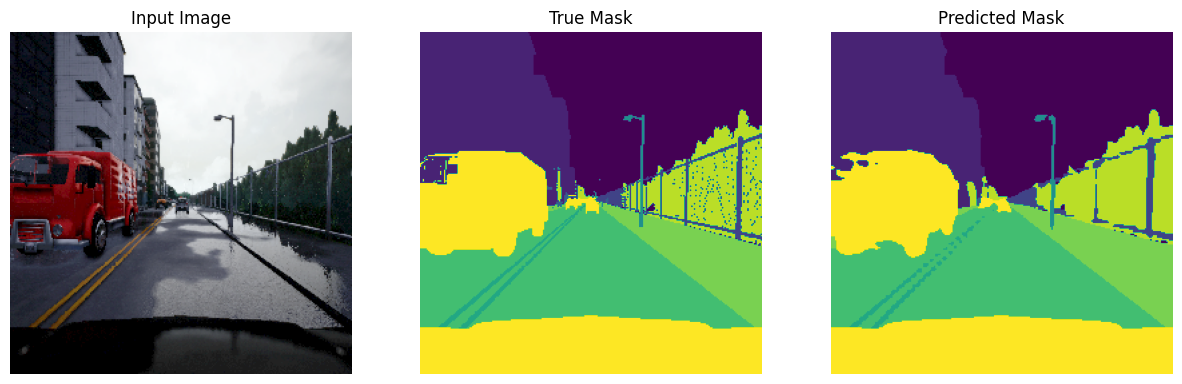

1/1 [==============================] - 0s 60ms/step


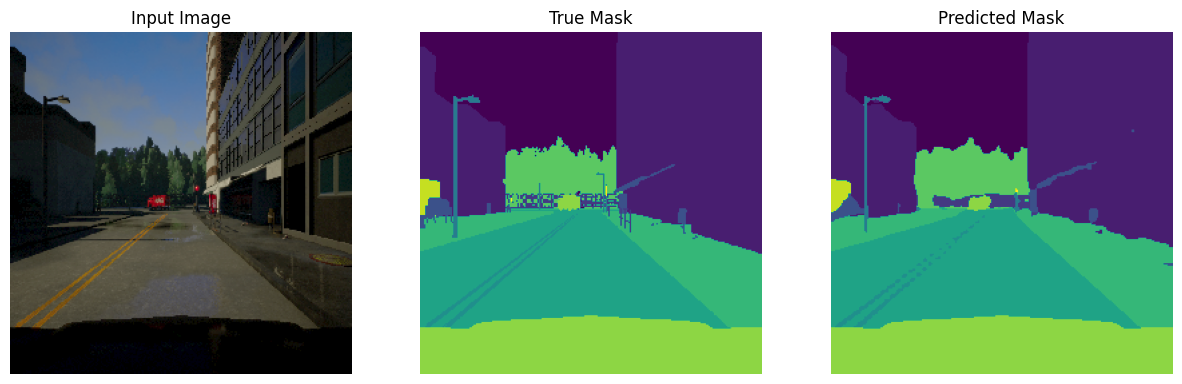

1/1 [==============================] - 0s 38ms/step


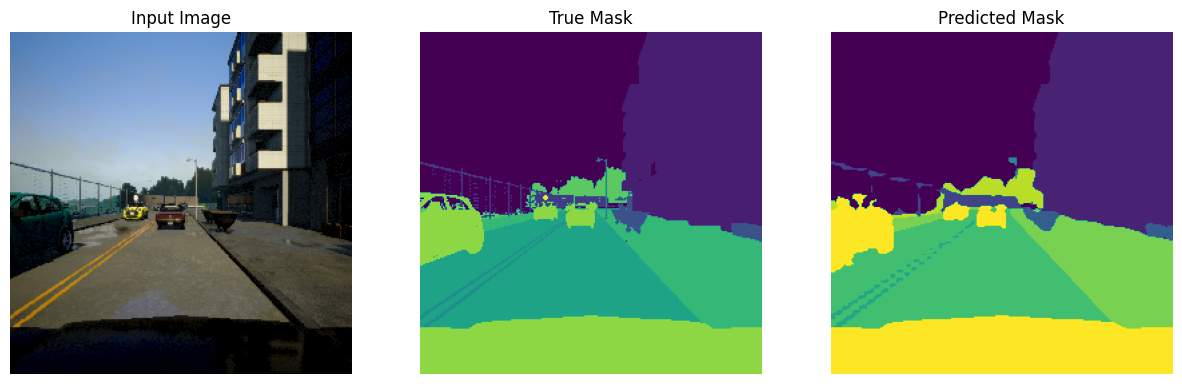

1/1 [==============================] - 0s 48ms/step


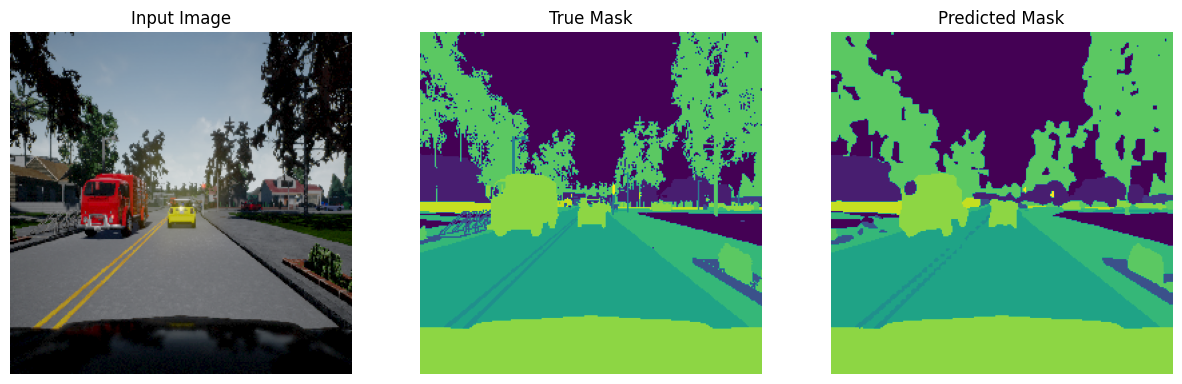

In [76]:
show_predictions(tests_dataset, 5)